# Exercise 10 - Neural Network Representational Capacity
## Tasks
- Change the number of neurons in the hidden layers and the number of layers. Observe how the output changes and how the number of parameters changes (checked with summary from the torchsummary package).
-  Derive a formula for the number of trainable parameters assuming two input neurons, one output neuron, $N_d$ hidden layers with $N_w$ neurons each. What is the number of biases $N_b$ and
the number of weights $N_w$ ? Verify your result with the output from summary.

## Learning Goals
- Visualize and compare the potential neural network capacity of different architectures


## Attribution 
This task is inspired by https://github.com/FlorianMarquardt/machine-learning-for-physicists/blob/master/02_tutorial_completed_NetworkTrainingVisualization.ipynb.

___

**Importações principais**    
Importamos o PyTorch e o `torchinfo`, que permite visualizar a estrutura da rede neural com número de parâmetros.

```python
import torch
from torchinfo import summary  # requer: pip install torchinfo
```

**Configuração do dispositivo**  
Seleciona automaticamente GPU (CUDA) se disponível, ou CPU caso contrário.  
```Python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
```

**Inicialização customizada dos pesos**  
Define uma função para inicializar pesos e bias de camadas lineares/convolucionais com valores aleatórios de distribuição uniforme.  

```Python
def initWeights(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.Conv3d)):
        torch.nn.init.uniform_(m.weight, a=-10, b=10)
        torch.nn.init.uniform_(m.bias, a=-1, b=1)
```

**Definição da rede neural**  
Cria uma classe com múltiplas camadas lineares e funções de ativação, organizadas em sequência.  

```Python
class NN(torch.nn.Module):
    def __init__(self, inputDimension, hiddenDimensions, outputDimension, activationFunction=torch.nn.Tanh()):
        super().__init__()
        modules = []
        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1]))
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))
        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)
```

**Configuração da arquitetura da rede**  
Define número de camadas, neurônios, ativação e fixa uma semente para reprodutibilidade.

```Python
torch.manual_seed(5)
numberOfHiddenNeurons = 100
numberOfLayers = 10
hiddenDimensions = [numberOfHiddenNeurons] * numberOfLayers
activationFunction = torch.nn.Sigmoid()
```

**Instanciação e preparação do modelo**  
Cria a rede, aplica inicialização personalizada e move para o dispositivo definido (CPU/GPU).

```Python
model = NN(2, hiddenDimensions, 1, activationFunction)
model.apply(initWeights)
model = model.to(device)
```

**Resumo da arquitetura da rede**  
Mostra camadas, parâmetros e forma das entradas/saídas com o torchinfo.

```Python
summary(model, (1, 2))
```

Geração da malha de entrada 2D
Cria um grid de coordenadas (x, y) que servirá como entrada para a rede.

```Python
Nx = 1000
Ny = 500
x = torch.linspace(-1, 1, Nx, device=device)
y = torch.linspace(-0.5, 0.5, Ny, device=device)
x, y = torch.meshgrid(x, y, indexing="ij")
input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
```

**Forward pass sem gradiente**  
Executa a rede sobre a malha de entrada e prepara a saída para visualização.

```Python
with torch.no_grad():
    output = model(input).detach().reshape((Nx, Ny)).cpu()
```

**Visualização estática com matplotlib**  
Plota a saída da rede como um mapa de calor 2D com colormap "inferno".

```Python
INTERACTIVE_PLOT = False

if not INTERACTIVE_PLOT:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12, 6))
    cp = ax.pcolormesh(x.cpu(), y.cpu(), output, cmap=plt.cm.inferno, shading='auto')
    plt.title('Network output visualization')
    plt.colorbar(cp)
    plt.show()
```

**Visualização interativa com zoom (opcional)**  
Permite clicar e arrastar para dar zoom em regiões específicas, recalculando a saída da rede em alta resolução.

```Python
else:
    import matplotlib
    matplotlib.use('qtagg')  # para interatividade
    import matplotlib.pyplot as plt

    class ZoomPlot():
        def __init__(self):
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(111)
            self.xmin, self.xmax = -2., 2.
            self.ymin, self.ymax = -2., 2.
            self.xpress, self.xrelease = self.xmin, self.xmax
            self.ypress, self.yrelease = self.ymin, self.ymax
            self.resolution = 400

            self.fig.canvas.mpl_connect('button_press_event', self.onpress)
            self.fig.canvas.mpl_connect('button_release_event', self.onrelease)
            self.plot_fixed_resolution(self.xmin, self.xmax, self.ymin, self.ymax)

        def plot_fixed_resolution(self, x1, x2, y1, y2):
            x = torch.linspace(x1, x2, self.resolution, device=device)
            y = torch.linspace(y1, y2, self.resolution, device=device)
            x, y = torch.meshgrid(x, y, indexing="ij")
            input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
            with torch.no_grad():
                output = model(input).detach().reshape((self.resolution, self.resolution)).cpu()

            self.ax.clear()
            self.ax.set_xlim(x1, x2)
            self.ax.set_ylim(y1, y2)
            self.ax.pcolormesh(x.cpu(), y.cpu(), output, cmap=plt.cm.inferno, shading='auto')
            plt.title('Interactive plot - click and drag to zoom')
            plt.show()
            self.fig.canvas.draw()

        def onpress(self, event):
            if event.button != 1: return
            self.xpress = event.xdata
            self.ypress = event.ydata

        def onrelease(self, event):
            if event.button != 1: return
            self.xrelease = event.xdata
            self.yrelease = event.ydata
            self.xmin, self.xmax = min(self.xpress, self.xrelease), max(self.xpress, self.xrelease)
            self.ymin, self.ymax = min(self.ypress, self.yrelease), max(self.ypress, self.yrelease)
            self.plot_fixed_resolution(self.xmin, self.xmax, self.ymin, self.ymax)

    plot = ZoomPlot()
```

Using device: cuda


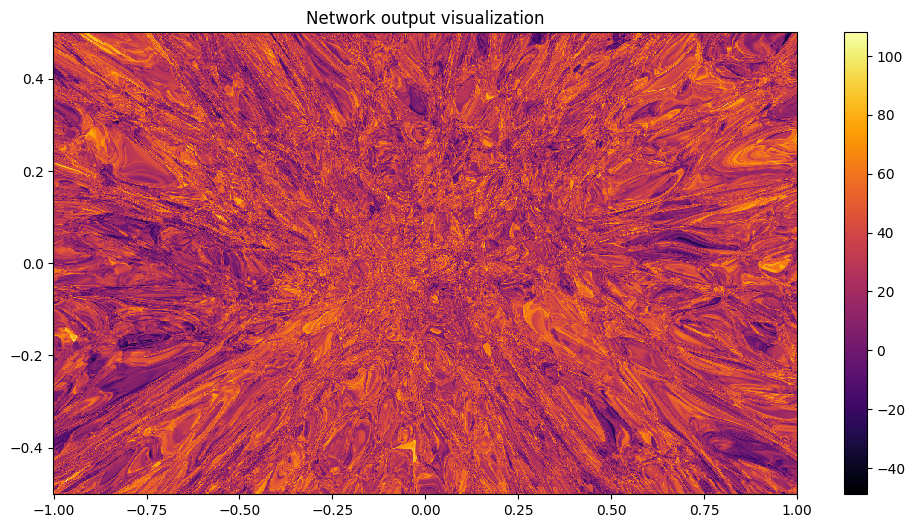

In [1]:
import torch
from torchinfo import summary       # requer: pip install torchinfo

# Escolher o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Inicialização customizada
def initWeights(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.Conv3d)):
        torch.nn.init.uniform_(m.weight, a=-10, b=10)
        torch.nn.init.uniform_(m.bias, a=-1, b=1)

# Rede neural
class NN(torch.nn.Module):
    def __init__(self, inputDimension, hiddenDimensions, outputDimension, activationFunction=torch.nn.Tanh()):
        super().__init__()
        modules = []
        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1]))
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))
        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

# Configurações
torch.manual_seed(5)
numberOfHiddenNeurons = 100
numberOfLayers = 10
hiddenDimensions = [numberOfHiddenNeurons] * numberOfLayers
activationFunction = torch.nn.Sigmoid()

# Modelo
model = NN(2, hiddenDimensions, 1, activationFunction)
model.apply(initWeights)
model = model.to(device)

# Sumário
summary(model, (1, 2))

# Geração da malha
Nx = 1000
Ny = 500
x = torch.linspace(-1, 1, Nx, device=device)
y = torch.linspace(-0.5, 0.5, Ny, device=device)
x, y = torch.meshgrid(x, y, indexing="ij")
input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)

# Forward sem gradientes
with torch.no_grad():
    output = model(input).detach().reshape((Nx, Ny)).cpu()

# Visualização estática
INTERACTIVE_PLOT = False

if not INTERACTIVE_PLOT:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12, 6))
    cp = ax.pcolormesh(x.cpu(), y.cpu(), output, cmap=plt.cm.inferno, shading='auto')
    plt.title('Network output visualization')
    plt.colorbar(cp)
    plt.show()

else:
    import matplotlib
    matplotlib.use('qtagg')  # para interativo (só se necessário)
    import matplotlib.pyplot as plt



    class ZoomPlot():
        def __init__(self):
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(111)
            self.xmin, self.xmax = -2., 2.
            self.ymin, self.ymax = -2., 2.
            self.xpress, self.xrelease = self.xmin, self.xmax
            self.ypress, self.yrelease = self.ymin, self.ymax
            self.resolution = 400

            self.fig.canvas.mpl_connect('button_press_event', self.onpress)
            self.fig.canvas.mpl_connect('button_release_event', self.onrelease)
            self.plot_fixed_resolution(self.xmin, self.xmax, self.ymin, self.ymax)

        def plot_fixed_resolution(self, x1, x2, y1, y2):
            x = torch.linspace(x1, x2, self.resolution, device=device)
            y = torch.linspace(y1, y2, self.resolution, device=device)
            x, y = torch.meshgrid(x, y, indexing="ij")
            input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
            with torch.no_grad():
                output = model(input).detach().reshape((self.resolution, self.resolution)).cpu()

            self.ax.clear()
            self.ax.set_xlim(x1, x2)
            self.ax.set_ylim(y1, y2)
            self.ax.pcolormesh(x.cpu(), y.cpu(), output, cmap=plt.cm.inferno, shading='auto')
            plt.title('Interactive plot - click and drag to zoom')
            plt.show()
            self.fig.canvas.draw()

        def onpress(self, event):
            if event.button != 1: return
            self.xpress = event.xdata
            self.ypress = event.ydata

        def onrelease(self, event):
            if event.button != 1: return
            self.xrelease = event.xdata
            self.yrelease = event.ydata
            self.xmin, self.xmax = min(self.xpress, self.xrelease), max(self.xpress, self.xrelease)
            self.ymin, self.ymax = min(self.ypress, self.yrelease), max(self.ypress, self.yrelease)
            self.plot_fixed_resolution(self.xmin, self.xmax, self.ymin, self.ymax)

    plot = ZoomPlot()


# Alguns exemplos avaliados no questionamento 1:

    1 camada com 5 neurônios:

        Saída simples e com padrões suaves  
        Número baixo de parâmetros

    10 camadas com 100 neurônios cada:

        Saída rica e complexa (estilo fractal)  
        Aumento exponencial dos parâmetros (acima de 30 mil)


Conforme aumentamos o número de camadas e/ou neurônios, a rede passa a ter maior capacidade de representação, o que reflete em:  

        Padrões mais detalhados e complexos na saída  
        Maior número de parâmetros (o que exige mais memória e tempo de treinamento)

Contudo, redes mais profundas e largas também são mais propensas ao overfitting e exigem técnicas adicionais de regularização e otimização.

# Questionamento 2:  

O objetivo é derivar a fórmula para calcular o número total de parâmetros treináveis (pesos e bias) de uma rede neural totalmente conectada, com a seguinte estrutura:

    2 neurônios de entrada  
    Nd​ camadas ocultas   
    Nw​ neurônios por camada oculta  
    1 neurônio de saída

A fórmula será validada empiricamente com a função summary() do pacote torchinfo.  

**Fórmulas finais**

Total de pesos (W)
\begin{equation}
W = 2N_w + (N_d - 1)N_w^2 + N_w
\end{equation})

Total de biases (B)
\begin{equation}
B = N_d \cdot N_w + 1
\end{equation}

Total de parâmetros (P) 
\begin{equation}
P = W + B = 2N_w + (N_d - 1)N_w^2 + N_w + N_d \cdot N_w + 1
\end{equation}

**Exemplo prático**  

Considerar uma rede com:


  $N_d = 3$ camadas ocultas  
  $N_w = 4$ neurônios por camada


**Cálculo dos Pesos**  

\begin{equation}
W = 2N_w + (N_d - 1)N_w^2 + N_w = 2 \cdot 4 + (3 - 1) \cdot 4^2 + 4 = 8 + 32 + 4 = 44
\end{equation}

**Cálculo dos Biases**

\begin{equation}
B = N_d \cdot N_w + 1 = 3 \cdot 4 + 1 = 12 + 1 = 13
\end{equation}

**Total de Parâmetros Treináveis**

\begin{equation}
P = W + B = 44 + 13 = 57
\end{equation}


**Conclusão**

A fórmula permite prever com exatidão o número de parâmetros treináveis de uma rede totalmente conectada com 2 entradas, múltiplas camadas ocultas e uma saída. Podemos utilizar para:

    Planejamento de capacidade do modelo  
    Controle do uso de memória  
    Comparação entre arquiteturas  
    Evitar complexidade desnecessária

